# Truss Analysis Implementation
- vanilla truss analysis

In [1]:
# in the previous code the elements were rectangles/quadrilaterals
# -> in this code they are BARS (LINES) = simpler!
# useful reference by Mert Solen (https://youtu.be/tv1TlAebvm0)

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# auxiliary ftions: extended_nodes updates
# returns local DOF matrix, global DOF matrix, tot num of DOC, tot num of DOF
def get_DOF(nodes, BC):
    num_nodes, PD = len(nodes), len(nodes[0])

    DOF = 0  # degrees of freedom
    DOC = 0  # degrees of constraint

    local_DOF = np.zeros((num_nodes, PD))
    global_DOF = np.zeros((num_nodes, PD))

    for i in range(num_nodes):
        for j in range(PD):
            if BC[i, j] == -1:
                DOC -= 1
                local_DOF[i, j] = DOC
            else:
                DOF += 1
                local_DOF[i, j] = DOF

    for i in range(num_nodes):
        for j in range(PD):
            if local_DOF[i, j] < 0:
                global_DOF[i, j] = abs(local_DOF[i, j]) + DOF
            else:
                global_DOF[i, j] = abs(local_DOF[i, j])

    return (local_DOF, global_DOF, abs(DOC), abs(DOF))

# obtain the element stiffness matrix based on the list of nodes in an element (el_list)
def get_element_stiffness(el_list, ext_nodes, E, A):
    X1 = ext_nodes[el_list[0], 0]
    Y1 = ext_nodes[el_list[0], 1]
    X2 = ext_nodes[el_list[1], 0]
    Y2 = ext_nodes[el_list[1], 1]

    L = np.sqrt((X1 - X2)**2 + (Y1 - Y2)**2)
    c = (X2 - X1) / L
    s = (Y2 - Y1) / L
    KE = E*A/L * np.array([[c**2, c * s, -c**2, -c * s],
                           [c * s, s**2, - c * s, -s**2],
                           [-c**2, -c * s, c**2, c * s],
                           [-c * s, -s**2, s * c, s**2]])
    return KE

# assemble the stiffness matrix K
def get_global_stiffness(nodes, conn, ext_nodes, E, A):
    num_nodes, num_el, PD = len(nodes), len(conn), len(nodes[0])
    K = np.zeros((num_nodes * PD, num_nodes * PD))  # init (global) stiffness matrix
    for i in range(num_el):  # obtain individual element stiffnesses
        element_list = conn[i,:]
        KE = get_element_stiffness(element_list, ext_nodes, E, A)
        for k in range(len(element_list)):  # for each node within element
            for l in range(PD):             # get each coordinate
                for m in range(len(element_list)):
                    for n in range(PD):
                        row = ext_nodes[element_list[k], l + 3*PD]
                        col = ext_nodes[element_list[m], n + 3*PD]
                        val = KE[k*PD + l, m*PD + n]

                        K[int(row) - 1, int(col) - 1] += val
    return K

# assemble the unknown forces
def get_forces(nodes, ext_nodes):
    num_nodes, PD = len(nodes), len(nodes[0])
    DOF = 0
    F_new = []

    for i in range(num_nodes):  # for each node
        for j in range(PD):     # for each dimension
            if ext_nodes[i, PD + j] == 1: # if node is not fixed
                DOF += 1
                F_new.append(ext_nodes[i, 5*PD+j])
    return np.array(F_new)

# assemble the unknown displacements
def get_displacements(nodes, ext_nodes):
    num_nodes, PD = len(nodes), len(nodes[0])
    DOC = 0
    U_new = []

    for i in range(num_nodes):  # for each node
        for j in range(PD):     # for each dimension
            if ext_nodes[i, PD + j] == -1: # if node is not fixed
                DOC += 1
                U_new.append(ext_nodes[i, 4*PD+j])
    return np.array(U_new)

# updates the extended nodes with the solution values for displacements and forces
def update_ext_nodes(nodes, ext_nodes, U_new, F_u):
    num_nodes, PD = len(nodes), len(nodes[0])

    DOF = 0  # degrees of freedom
    DOC = 0  # degrees of constraint

    for i in range(num_nodes):
        for j in range(PD):
            if ext_nodes[i, PD+j] == 1:
                DOF += 1
                ext_nodes[i, 4*PD + j] = U_new[DOF - 1]
            else:
                DOC += 1
                ext_nodes[i, 5*PD + j] = F_u[DOC - 1]
    return ext_nodes

# plotting mesh - function call:    plot_mesh(nodes, conn, plot_connections=True)
def plot_mesh(nodes, conn, plot_connections=True, size=10):
    plt.figure(figsize=(size,size))
    plt.grid(color = 'gray', linewidth=0.2)

    if plot_connections:  # plotting connections
        connections = set()
        for el in conn:
            if len(el) == 2:  # for bar elements
                c1 = (el[0], el[1])
                connections.add(c1)
            if len(el) == 4:
                c1, c2, c3, c4 = (el[0], el[1]), (el[1], el[2]), (el[2], el[3]), (el[3], el[0])
                connections.add(c1); connections.add(c2); connections.add(c3); connections.add(c4)
            elif len(el) == 3:
                c1, c2, c3 = (el[0], el[1]), (el[1], el[2]), (el[2], el[0])
                connections.add(c1); connections.add(c2); connections.add(c3)
        for (el1, el2) in connections:
            (x1, y1) = nodes[el1]
            (x2, y2) = nodes[el2]
            plt.plot([x1, x2], [y1, y2], linewidth=0.9, color='orange', marker='', zorder=1)

    plt.scatter(nodes[:,0], nodes[:,1], marker='o', color='b', s=5, zorder=2)  # plot nodes
    plt.axis('equal')
    plt.show()

# plotting nodes: numpy array of xs and ys
def plot_nodes(nodes, size=10):
    plt.figure(figsize=(size,size))
    plt.grid(color = 'gray', linewidth=0.2)
    plt.scatter(nodes[:,0], nodes[:,1], marker='o')
    plt.axis('equal')
    plt.title(f"num of nodes {num_nodes}")
    if size >= 8:  # print node labels
        for i,(x,y) in enumerate(nodes):
            plt.text(x, y, str(i))
    plt.show()


---
## Ex.1 - Simple triangle truss

In [2]:
# material specifications
E = 10.0 ** 6   # Youngs modulus
A = 0.01        # cross-section area of a bar

# defining the structure
nodes = np.array([[0, 0],
                  [1, 0],
                  [0.5, 1]])
conn = np.array([[0, 1],
                 [1, 2],
                 [2, 0]])
num_nodes = len(nodes)  # total number of nodes
PD = 2                  # problem dimension: 2D

# assigning boundary conditions (Dirichlet & Neumann BC)
BC = np.array([[-1, -1],  # (-1,-1) -> fixed in X and Y
               [1, -1],   # ( 1,-1) -> free to move in X and fixed in Y
               [1, 1]])   # ( 1, 1) -> free to move in X and Y


# assigning nodal forces
F = np.array([[0,  0],
              [0,  0],
              [0, -20]])

# initial displacements
U = np.array([[0, 0],
              [0, 0],
              [0, 0]])

# extended node list (ENL)
(localDOF, globalDOF, DOC, DOF) = get_DOF(nodes=nodes, BC=BC)  # get the DOF matrices
ext_nodes = np.zeros((num_nodes, 6 * PD))  # nodes, BC, local DoF, global DoF, Displacement, Forces
ext_nodes[:, 0:PD] = nodes          # first 2 columns are node list
ext_nodes[:, PD:2*PD] = BC          # boundary conditions
ext_nodes[:, 2*PD:3*PD] = localDOF  # local DOFs
ext_nodes[:, 3*PD:4*PD] = globalDOF # global DOFs
ext_nodes[:, 4*PD:5*PD] = U         # displacements
ext_nodes[:, 5*PD:6*PD] = F         # forces

K = get_global_stiffness(nodes=nodes, conn=conn, ext_nodes=ext_nodes, E=E, A=A)  # calculating global stiffness
U, F = U.flatten(), F.flatten()
print(F.shape)


# finding the new displacements and forces
F_p = get_forces(nodes, ext_nodes)        # force prescribed
U_p = get_displacements(nodes, ext_nodes) # displacement prescribed

print(F_p.shape)

# using F = K * U
K_UU = K[0:DOF, 0:DOF]
K_UP = K[0:DOF, DOF:DOF+DOC]
K_PU = K[DOF:DOF+DOC, 0:DOF]
K_PP = K[DOF:DOF+DOC, DOF:DOF+DOC]


F_com = F_p - np.matmul(K_UP, U_p)                            # 'combined' F
U_new = np.matmul(np.linalg.inv(K_UU), F_com)                 # the nodal displacements
F_new = np.matmul(K_PU, U_new) + np.matmul(K_PP, U_p)         # the nodal forces
ext_nodes = update_ext_nodes(nodes, ext_nodes, U_new, F_new)  # matrix with solutions

print(F_com.shape)
print(F_com, U_new, F_new)
print(ext_nodes)



(6,)
(3,)
(3,)
[  0.   0. -20.] [ 0.0005      0.00025    -0.00152254] [-8.8817842e-16  1.0000000e+01  1.0000000e+01]
[[ 0.00000000e+00  0.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -2.00000000e+00  4.00000000e+00  5.00000000e+00
   0.00000000e+00  0.00000000e+00 -8.88178420e-16  1.00000000e+01]
 [ 1.00000000e+00  0.00000000e+00  1.00000000e+00 -1.00000000e+00
   1.00000000e+00 -3.00000000e+00  1.00000000e+00  6.00000000e+00
   5.00000000e-04  0.00000000e+00  0.00000000e+00  1.00000000e+01]
 [ 5.00000000e-01  1.00000000e+00  1.00000000e+00  1.00000000e+00
   2.00000000e+00  3.00000000e+00  2.00000000e+00  3.00000000e+00
   2.50000000e-04 -1.52254249e-03  0.00000000e+00 -2.00000000e+01]]


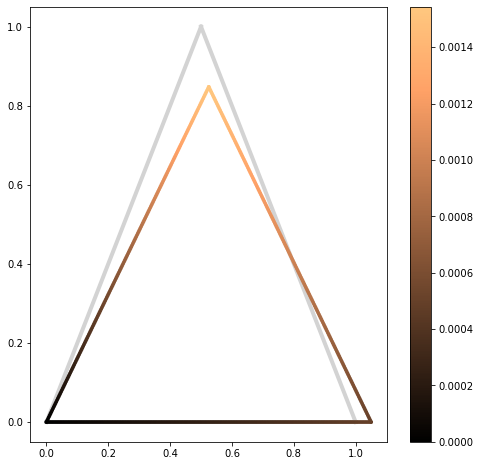

In [3]:
ex = 100               # exaggerate the displacement (for display)
interpolation_num = 200  # how many points to add in each element
num_nodes, num_el, PD = len(nodes), len(conn), len(nodes[0])


x_new = nodes[:, 0] + ex * ext_nodes[:, 8]  # new coordinates x
y_new = nodes[:, 1] + ex * ext_nodes[:, 9]  # new coordinates y
x_old = ext_nodes[:, 0]                    # initial coordinates x
y_old = ext_nodes[:, 1]                    # initial coordinates y

U_abs = np.sqrt(ext_nodes[:,8]**2 + ext_nodes[:, 9]**2)   # absolute displacements




xs, ys, colors = [], [], []    # init plotting points and colors
# plotting the lines with different colors (linearly interpolated points)
for i in range(num_el):  # for each element
    inds = conn[i]
    x1, y1 = x_new[inds[0]], y_new[inds[0]]
    x2, y2 = x_new[inds[1]], y_new[inds[1]]
    if x1 == x2:
        xs_i = np.linspace(x1, x2, interpolation_num)
        ys_i = np.linspace(y1, y2, interpolation_num)
    else:
        a = (y2 - y1)/(x2 - x1)  # slope
        xs_i = np.linspace(x1, x2, interpolation_num)
        ys_i = a*(xs_i - x1) + y1

    xs.append(xs_i)
    ys.append(ys_i)
    colors.append(np.linspace(U_abs[inds[0]], U_abs[inds[1]], interpolation_num))
xs, ys, colors = np.array(xs), np.array(ys), np.array(colors)
xs, ys, colors = xs.flatten(), ys.flatten(), colors.flatten()

f1 = plt.figure(figsize=(8,8)) # init the figure
ax1 = f1.add_subplot(111)      # init the axes

# plotting the original structure
for i in range(num_el):  # for each element
    inds = conn[i]
    x1, y1 = x_old[inds[0]], y_old[inds[0]]
    x2, y2 = x_old[inds[1]], y_old[inds[1]]
    ax1.plot([x1, x2], [y1, y2], linewidth=4, color='lightgray', marker='', zorder=1)

# plotting the new displacements
cmap = plt.get_cmap('copper')
ax1.scatter(xs, ys, c=colors, cmap=cmap, s=14, edgecolor='None', zorder=2)
color_scale = Normalize(np.abs(colors.min()), np.abs(colors.max()))  # scale to use in the colorbar
f1.colorbar(ScalarMappable(norm=color_scale, cmap=cmap))

plt.show()

---
## Ex.2 - Square outline truss 1 (naive approach)
- this approach does not work -> statistically indeterminate

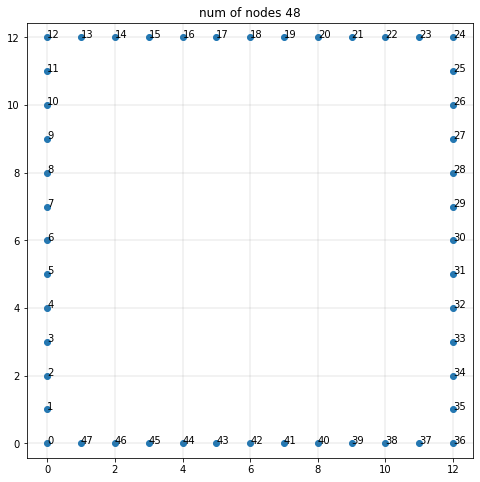

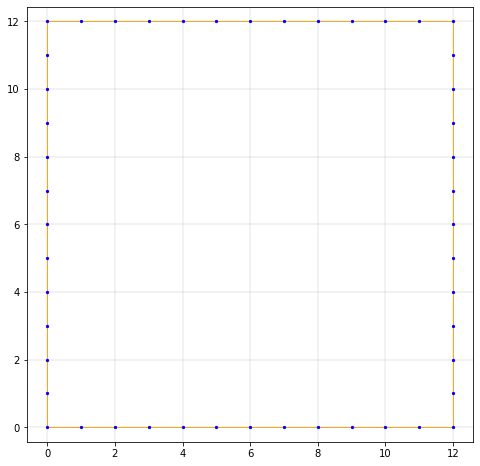

LinAlgError: Singular matrix

In [4]:
# using Truss Analysis for more complicated structure: SIMPLE SQUARE OUTLINE
# LOADING: ->[]<-
# !!! simple square outline CANNOT WORK! 'statistically indeterminate / singular matrix'
# !!! "LinAlgError: Singular matrix"


# material specifications
E = 10.0 ** 6   # Youngs modulus
A = 0.01        # cross-section area of a bar


# defining the structure
width, height = 12, 12      # dimensions of the square
num_el_x, num_el_y = 12, 12 # num of elements

dx, dy = width / num_el_x, height / num_el_y
num_nodes = 2*(num_el_x + num_el_y) # number of nodes
PD = 2                              # problem dimension: 2D

nodes = []
x, y = 0, 0
for i in range(num_el_y-1):  # LEFT
    nodes.append([x, y])
    y += dy
nodes.append([x,y])
y += dy
for i in range(num_el_x-1):  # TOP
    nodes.append([x,y])
    x += dx
nodes.append([x,y])
x += dx
for i in range(num_el_y-1):  # RIGHT
    nodes.append([x, y])
    y -= dy
nodes.append([x,y])
y -= dy
for i in range(num_el_x-1):  # BOTTOM
    nodes.append([x,y])
    x -= dx
nodes.append([x,y])
nodes = np.array(nodes)

conn = [[i, i+1] for i in range(num_nodes - 1)]  # # list of connections for each element
conn.append([num_nodes - 1, 0])
conn = np.array(conn)


plot_nodes(nodes, size=8)                             # plotting the mesh
plot_mesh(nodes, conn, plot_connections=True, size=8) # plotting the mesh


# assigning boundary conditions (Dirichlet & Neumann BC)
BC = np.ones((num_nodes, PD))  # init the BC conditions
for i in range(num_nodes):
    (x, y) = nodes[i]

    if height / 2 <= y < height / 2 + dy:
        if x < width // 2:
            BC[i, :] = [-1, -1]  # fix the point in X and Y
        elif x > width // 2:
            BC[i, :] = [1, -1]  # fix the point in Y


# assigning nodal forces
F = np.zeros((num_nodes, PD))
for i in range(num_nodes):
    (x, y) = nodes[i]

    if height / 2 <= y < height / 2 + dy:
        if x > width // 2:
            F[i, :] = [-10, 0]  # fix the point in Y


# initial displacements
U = np.zeros((num_nodes, PD))


# extended node list (ENL)
(localDOF, globalDOF, DOC, DOF) = get_DOF(nodes=nodes, BC=BC)  # get the DOF matrices
ext_nodes = np.zeros((num_nodes, 6 * PD))  # nodes, BC, local DoF, global DoF, Displacement, Forces
ext_nodes[:, 0:PD] = nodes          # first 2 columns are node list
ext_nodes[:, PD:2*PD] = BC          # boundary conditions
ext_nodes[:, 2*PD:3*PD] = localDOF  # local DOFs
ext_nodes[:, 3*PD:4*PD] = globalDOF # global DOFs
ext_nodes[:, 4*PD:5*PD] = U         # displacements
ext_nodes[:, 5*PD:6*PD] = F         # forces


# calculating the global stiffness matrix
K = get_global_stiffness(nodes=nodes, conn=conn, ext_nodes=ext_nodes, E=E, A=A)
U, F = U.flatten(), F.flatten()


# finding the new displacements and forces
F_p = get_forces(nodes, ext_nodes)        # force prescribed
U_p = get_displacements(nodes, ext_nodes) # displacement prescribed


# using F = K * U
K_UU = K[0:DOF, 0:DOF]
K_UP = K[0:DOF, DOF:DOF+DOC]
K_PU = K[DOF:DOF+DOC, 0:DOF]
K_PP = K[DOF:DOF+DOC, DOF:DOF+DOC]

F_com = F_p - np.matmul(K_UP, U_p)                            # 'combined' F
U_new = np.matmul(np.linalg.inv(K_UU), F_com)                 # the nodal displacements
F_new = np.matmul(K_PU, U_new) + np.matmul(K_PP, U_p)         # the nodal forces
ext_nodes = update_ext_nodes(nodes, ext_nodes, U_new, F_new)  # matrix with solutions

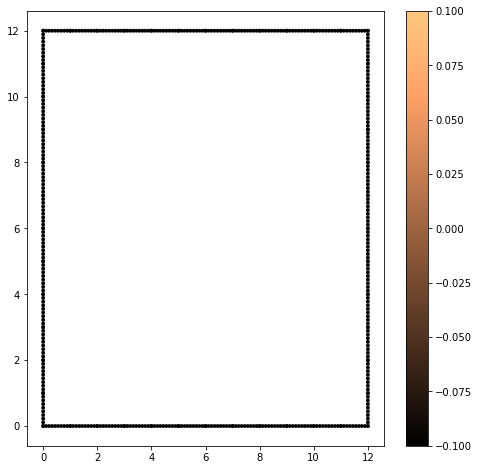

In [5]:
# visualisation

ex = 100               # exaggerate the displacement (for display)
interpolation_num = 10  # how many points to add in each element
num_nodes, num_el, PD = len(nodes), len(conn), len(nodes[0])


x_new = nodes[:, 0] + ex * ext_nodes[:, 8]  # new coordinates x
y_new = nodes[:, 1] + ex * ext_nodes[:, 9]  # new coordinates y
x_old = ext_nodes[:, 0]                    # initial coordinates x
y_old = ext_nodes[:, 1]                    # initial coordinates y
U_abs = np.sqrt(ext_nodes[:,8]**2 + ext_nodes[:, 9]**2)   # absolute displacements




xs, ys, colors = [], [], []    # init plotting points and colors
# plotting the lines with different colors (linearly interpolated points)
for i in range(num_el):  # for each element
    inds = conn[i]
    x1, y1 = x_new[inds[0]], y_new[inds[0]]
    x2, y2 = x_new[inds[1]], y_new[inds[1]]
    if x1 == x2:
        xs_i = np.linspace(x1, x2, interpolation_num)
        ys_i = np.linspace(y1, y2, interpolation_num)
    else:
        a = (y2 - y1)/(x2 - x1)  # slope
        xs_i = np.linspace(x1, x2, interpolation_num)
        ys_i = a*(xs_i - x1) + y1

    xs.append(xs_i)
    ys.append(ys_i)
    colors.append(np.linspace(U_abs[inds[0]], U_abs[inds[1]], interpolation_num))
xs, ys, colors = np.array(xs), np.array(ys), np.array(colors)
xs, ys, colors = xs.flatten(), ys.flatten(), colors.flatten()

f1 = plt.figure(figsize=(8,8)) # init the figure
ax1 = f1.add_subplot(111)      # init the axes

# plotting the original structure
for i in range(num_el):  # for each element
    inds = conn[i]
    x1, y1 = x_old[inds[0]], y_old[inds[0]]
    x2, y2 = x_old[inds[1]], y_old[inds[1]]
    ax1.plot([x1, x2], [y1, y2], linewidth=4, color='lightgray', marker='', zorder=1)

# plotting the new displacements
cmap = plt.get_cmap('copper')
ax1.scatter(xs, ys, c=colors, cmap=cmap, s=14, edgecolor='None', zorder=2)
color_scale = Normalize(np.abs(colors.min()), np.abs(colors.max()))  # scale to use in the colorbar
f1.colorbar(ScalarMappable(norm=color_scale, cmap=cmap))

plt.show()

---
## Ex.3 - square outline 2 ('triangulation' approach)

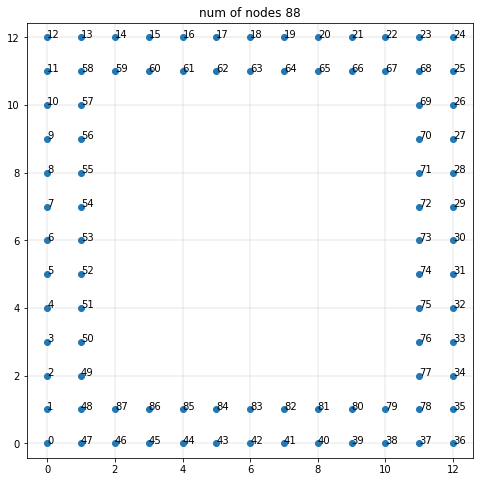

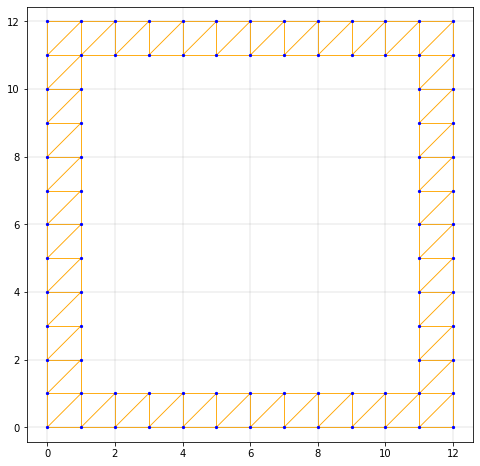

In [4]:
# using Truss Analysis for more complicated structure: TRIANGULATED SQUARE OUTLINE
# LOADING: ->[]<-

# material specifications
E = 2000#10.0 ** 6   # Youngs modulus
A = 1#0.01        # cross-section area of a bar


# defining the structure
width, height = 12, 12      # dimensions of the square
num_el_x, num_el_y = 12, 12 # num of elements

dx, dy = width / num_el_x, height / num_el_y

nodes = []
x, y = 0, 0  # OUTER
for i in range(num_el_y-1):  # LEFT
    nodes.append([x, y])
    y += dy
nodes.append([x,y])
y += dy
for i in range(num_el_x-1):  # TOP
    nodes.append([x,y])
    x += dx
nodes.append([x,y])
x += dx
for i in range(num_el_y-1):  # RIGHT
    nodes.append([x, y])
    y -= dy
nodes.append([x,y])
y -= dy
for i in range(num_el_x-1):  # BOTTOM
    nodes.append([x,y])
    x -= dx
nodes.append([x,y])

x, y = dx, dy  # INNER
for i in range(num_el_y-3):  # LEFT
    nodes.append([x, y])
    y += dy
nodes.append([x,y])
y += dy
for i in range(num_el_x-3):  # TOP
    nodes.append([x,y])
    x += dx
nodes.append([x,y])
x += dx
for i in range(num_el_y-3):  # RIGHT
    nodes.append([x, y])
    y -= dy
nodes.append([x,y])
y -= dy
for i in range(num_el_x-3):  # BOTTOM
    nodes.append([x,y])
    x -= dx
nodes.append([x,y])

nodes = np.array(nodes)

num_nodes = len(nodes)              # number of nodes
PD = 2                              # problem dimension: 2D
num_out = 2*(num_el_x + num_el_y)   # nodes in the outer square
num_in = num_nodes - num_out        # nodes in the inner square


conn = []  # init list of connections for each element
outer = [[i, i+1] for i in range(num_out - 1)]
inner = [[i, i+1] for i in range(num_out, num_out + num_in - 1)]  #
cross1 = [[i, i + num_out] for i in range(1, num_el_y - 1)]
cross2 = [[i + num_out -4, i] for i in range(num_el_y + 2, num_el_y + num_el_x)]
cross3 = [[i + num_out - 4, i] for i in range(num_el_y + num_el_x + 1 , num_el_y + num_el_x + num_el_y - 1)]
cross4 = [[i, i + num_out - 8] for i in range(num_out - num_el_x + 2 , num_out )]
horiz1 = [[i, i + num_out - 1] for i in range(1, num_el_y)]
horiz2 = [[i + num_out - 4, i - 1] for i in range(num_el_y + 2, num_el_y + num_el_x + 1)]
horiz3 = [[i + num_out - 4 - 1, i] for i in range(num_el_y + num_el_x + 1 , num_el_y + num_el_x + num_el_y)]
horiz4 = [[i - 1, i + num_out - 8] for i in range(num_out - num_el_x + 2 , num_out)]

corner1 = [0, num_out]
corner2 = [num_el_y-1, num_el_y + 1]
corner3 = [num_nodes - num_el_x - num_el_y + 4, num_el_y + num_el_x]
corner4 = [2*num_el_y + num_el_x + 1, 2*num_el_y + num_el_x - 1]

conn += outer
conn.append([num_out - 1, 0])
conn += inner
conn.append([num_nodes - 1, num_out])
conn.append(corner1)
conn += cross1
conn.append(corner2)
conn += cross2
conn.append(corner3)
conn += cross3
conn.append(corner4)
conn += cross4
conn += horiz1
conn += horiz2
conn += horiz3
conn += horiz4
conn.append([num_out-1, num_out])

conn = np.array(conn)


plot_nodes(nodes, size=8)                             # plotting the mesh
plot_mesh(nodes, conn, plot_connections=True, size=8) # plotting the mesh


# assigning boundary conditions (Dirichlet & Neumann BC)
BC = np.ones((num_nodes, PD))  # init the BC conditions
for i in range(num_nodes):
    (x, y) = nodes[i]

    if height / 2 <= y < height / 2 + dy:
        if x < width // 2:
            BC[i, :] = [-1, -1]  # fix the point in X and Y
        # elif x > width // 2:
        #     BC[i, :] = [1, -1]  # fix the point in Y


# assigning nodal forces
F = np.zeros((num_nodes, PD))
for i in range(num_nodes):
    (x, y) = nodes[i]

    if height / 2 <= y < height / 2 + dy:
        if x > width // 2:
            F[i, :] = [-20, 0]  # fix the point in Y


# initial displacements
U = np.zeros((num_nodes, PD))


# extended node list (ENL)
(localDOF, globalDOF, DOC, DOF) = get_DOF(nodes=nodes, BC=BC)  # get the DOF matrices
ext_nodes = np.zeros((num_nodes, 6 * PD))  # nodes, BC, local DoF, global DoF, Displacement, Forces
ext_nodes[:, 0:PD] = nodes          # first 2 columns are node list
ext_nodes[:, PD:2*PD] = BC          # boundary conditions
ext_nodes[:, 2*PD:3*PD] = localDOF  # local DOFs
ext_nodes[:, 3*PD:4*PD] = globalDOF # global DOFs
ext_nodes[:, 4*PD:5*PD] = U         # displacements
ext_nodes[:, 5*PD:6*PD] = F         # forces


# calculating the global stiffness matrix
K = get_global_stiffness(nodes=nodes, conn=conn, ext_nodes=ext_nodes, E=E, A=A)
U, F = U.flatten(), F.flatten()


# finding the new displacements and forces
F_p = get_forces(nodes, ext_nodes)        # force prescribed
U_p = get_displacements(nodes, ext_nodes) # displacement prescribed


# using F = K * U
K_UU = K[0:DOF, 0:DOF]
K_UP = K[0:DOF, DOF:DOF+DOC]
K_PU = K[DOF:DOF+DOC, 0:DOF]
K_PP = K[DOF:DOF+DOC, DOF:DOF+DOC]

F_com = F_p - np.matmul(K_UP, U_p)                            # 'combined' F
U_new = np.matmul(np.linalg.inv(K_UU), F_com)                 # the nodal displacements
F_new = np.matmul(K_PU, U_new) + np.matmul(K_PP, U_p)         # the nodal forces
ext_nodes = update_ext_nodes(nodes, ext_nodes, U_new, F_new)  # matrix with solutions

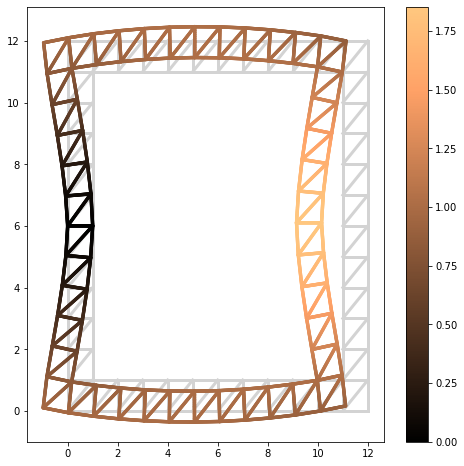

In [5]:
# visualisation code
ex = 1               # exaggerate the displacement (for display)
interpolation_num = 50  # how many points to add in each element
num_nodes, num_el, PD = len(nodes), len(conn), len(nodes[0])

x_new = nodes[:, 0] + ex * ext_nodes[:, 8]  # new coordinates x
y_new = nodes[:, 1] + ex * ext_nodes[:, 9]  # new coordinates y
x_old = ext_nodes[:, 0]                    # initial coordinates x
y_old = ext_nodes[:, 1]                    # initial coordinates y
U_abs = np.sqrt(ext_nodes[:,8]**2 + ext_nodes[:, 9]**2)   # absolute displacements

xs, ys, colors = [], [], []    # init plotting points and colors
# plotting the lines with different colors (linearly interpolated points)
for i in range(num_el):  # for each element
    inds = conn[i]
    x1, y1 = x_new[inds[0]], y_new[inds[0]]
    x2, y2 = x_new[inds[1]], y_new[inds[1]]
    if x1 == x2:
        xs_i = np.linspace(x1, x2, interpolation_num)
        ys_i = np.linspace(y1, y2, interpolation_num)
    else:
        a = (y2 - y1)/(x2 - x1)  # slope
        xs_i = np.linspace(x1, x2, interpolation_num)
        ys_i = a*(xs_i - x1) + y1

    xs.append(xs_i)
    ys.append(ys_i)
    colors.append(np.linspace(U_abs[inds[0]], U_abs[inds[1]], interpolation_num))
xs, ys, colors = np.array(xs), np.array(ys), np.array(colors)
xs, ys, colors = xs.flatten(), ys.flatten(), colors.flatten()

f1 = plt.figure(figsize=(8,8)) # init the figure
ax1 = f1.add_subplot(111)      # init the axes

# plotting the original structure
for i in range(num_el):  # for each element
    inds = conn[i]
    x1, y1 = x_old[inds[0]], y_old[inds[0]]
    x2, y2 = x_old[inds[1]], y_old[inds[1]]
    ax1.plot([x1, x2], [y1, y2], linewidth=3, color='lightgray', marker='', zorder=1)

# plotting the new displacements
cmap = plt.get_cmap('copper')
ax1.scatter(xs, ys, c=colors, cmap=cmap, s=12, edgecolor='None', zorder=2)
color_scale = Normalize(np.abs(colors.min()), np.abs(colors.max()))  # scale to use in the colorbar
f1.colorbar(ScalarMappable(norm=color_scale, cmap=cmap))

plt.show()

---
## Ex.4 - square outline modified

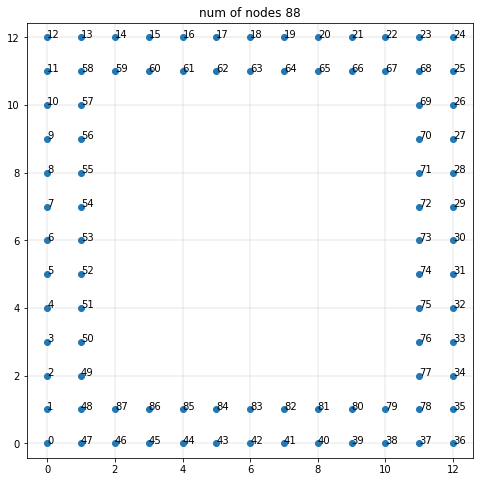

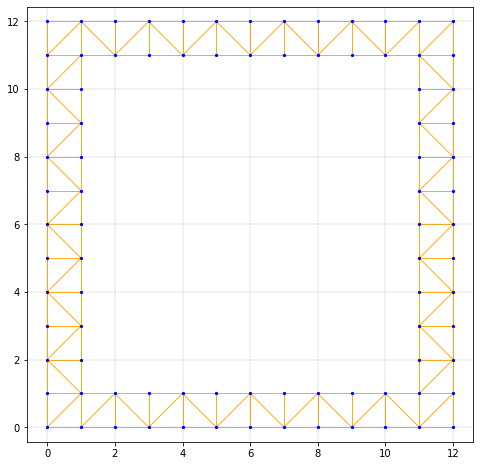

In [6]:
# using Truss Analysis for more complicated structure: TRIANGULATED SQUARE OUTLINE
# LOADING: ->[]<-

# material specifications
E = 2000#10.0 ** 6   # Youngs modulus
A = 1#0.01        # cross-section area of a bar


# defining the structure
width, height = 12, 12      # dimensions of the square
num_el_x, num_el_y = 12, 12 # num of elements

dx, dy = width / num_el_x, height / num_el_y

nodes = []
x, y = 0, 0  # OUTER
for i in range(num_el_y-1):  # LEFT
    nodes.append([x, y])
    y += dy
nodes.append([x,y])
y += dy
for i in range(num_el_x-1):  # TOP
    nodes.append([x,y])
    x += dx
nodes.append([x,y])
x += dx
for i in range(num_el_y-1):  # RIGHT
    nodes.append([x, y])
    y -= dy
nodes.append([x,y])
y -= dy
for i in range(num_el_x-1):  # BOTTOM
    nodes.append([x,y])
    x -= dx
nodes.append([x,y])

x, y = dx, dy  # INNER
for i in range(num_el_y-3):  # LEFT
    nodes.append([x, y])
    y += dy
nodes.append([x,y])
y += dy
for i in range(num_el_x-3):  # TOP
    nodes.append([x,y])
    x += dx
nodes.append([x,y])
x += dx
for i in range(num_el_y-3):  # RIGHT
    nodes.append([x, y])
    y -= dy
nodes.append([x,y])
y -= dy
for i in range(num_el_x-3):  # BOTTOM
    nodes.append([x,y])
    x -= dx
nodes.append([x,y])

nodes = np.array(nodes)

num_nodes = len(nodes)              # number of nodes
PD = 2                              # problem dimension: 2D
num_out = 2*(num_el_x + num_el_y)   # nodes in the outer square
num_in = num_nodes - num_out        # nodes in the inner square


conn = []  # init list of connections for each element
outer = [[i, i+1] for i in range(num_out - 1)]
inner = [[i, i+1] for i in range(num_out, num_out + num_in - 1)]  #
cross11 = [[i, i + num_out] for i in range(1, num_el_y - 1)]
cross12 = [[i + 1, i + num_out - 1] for i in range(1, num_el_y - 1)]
cross21 = [[i + num_out -4, i] for i in range(num_el_y + 2, num_el_y + num_el_x)]
cross22 = [[i + num_out -4 + 1, i - 1] for i in range(num_el_y + 2, num_el_y + num_el_x)]
cross31 = [[i + num_out - 4, i] for i in range(num_el_y + num_el_x + 1 , num_el_y + num_el_x + num_el_y - 1)]
cross32 = [[i + num_out - 4 - 1, i + 1] for i in range(num_el_y + num_el_x + 1 , num_el_y + num_el_x + num_el_y - 1)]
cross41 = [[i, i + num_out - 8] for i in range(num_out - num_el_x + 2 , num_out )]
cross42 = [[i - 1, i + num_out - 8 + 1] for i in range(num_out - num_el_x + 2 , num_out )]
horiz1 = [[i, i + num_out - 1] for i in range(1, num_el_y)]
horiz2 = [[i + num_out - 4, i - 1] for i in range(num_el_y + 2, num_el_y + num_el_x + 1)]
horiz3 = [[i + num_out - 4 - 1, i] for i in range(num_el_y + num_el_x + 1 , num_el_y + num_el_x + num_el_y)]
horiz4 = [[i - 1, i + num_out - 8] for i in range(num_out - num_el_x + 2 , num_out)]

corner1 = [0, num_out]
corner2 = [num_el_y-1, num_el_y + 1]
corner3 = [num_nodes - num_el_x - num_el_y + 4, num_el_y + num_el_x]
corner4 = [2*num_el_y + num_el_x + 1, 2*num_el_y + num_el_x - 1]

conn += outer
conn.append([num_out - 1, 0])
conn += inner
conn.append([num_nodes - 1, num_out])
conn.append(corner1)
conn += cross12[::2]
conn += cross11[1::2]
conn.append(corner2)
conn += cross22[::2]
conn += cross21[1::2]
conn.append(corner3)
conn += cross32[::2]
conn += cross31[1::2]
conn.append(corner4)
conn += cross42[::2]
conn += cross41[1::2]
conn += horiz1
conn += horiz2
conn += horiz3
conn += horiz4
conn.append([num_out-1, num_out])

conn = np.array(conn)


plot_nodes(nodes, size=8)                             # plotting the mesh
plot_mesh(nodes, conn, plot_connections=True, size=8) # plotting the mesh


# assigning boundary conditions (Dirichlet & Neumann BC)
BC = np.ones((num_nodes, PD))  # init the BC conditions
for i in range(num_nodes):
    (x, y) = nodes[i]

    if height / 2 <= y < height / 2 + dy:
        if x < width // 2:
            BC[i, :] = [-1, -1]  # fix the point in X and Y
        # elif x > width // 2:
        #     BC[i, :] = [1, -1]  # fix the point in Y


# assigning nodal forces
F = np.zeros((num_nodes, PD))
for i in range(num_nodes):
    (x, y) = nodes[i]

    if height / 2 <= y < height / 2 + dy:
        if x > width // 2:
            F[i, :] = [-20, 0]  # fix the point in Y


# initial displacements
U = np.zeros((num_nodes, PD))


# extended node list (ENL)
(localDOF, globalDOF, DOC, DOF) = get_DOF(nodes=nodes, BC=BC)  # get the DOF matrices
ext_nodes = np.zeros((num_nodes, 6 * PD))  # nodes, BC, local DoF, global DoF, Displacement, Forces
ext_nodes[:, 0:PD] = nodes          # first 2 columns are node list
ext_nodes[:, PD:2*PD] = BC          # boundary conditions
ext_nodes[:, 2*PD:3*PD] = localDOF  # local DOFs
ext_nodes[:, 3*PD:4*PD] = globalDOF # global DOFs
ext_nodes[:, 4*PD:5*PD] = U         # displacements
ext_nodes[:, 5*PD:6*PD] = F         # forces


# calculating the global stiffness matrix
K = get_global_stiffness(nodes=nodes, conn=conn, ext_nodes=ext_nodes, E=E, A=A)
U, F = U.flatten(), F.flatten()


# finding the new displacements and forces
F_p = get_forces(nodes, ext_nodes)        # force prescribed
U_p = get_displacements(nodes, ext_nodes) # displacement prescribed


# using F = K * U
K_UU = K[0:DOF, 0:DOF]
K_UP = K[0:DOF, DOF:DOF+DOC]
K_PU = K[DOF:DOF+DOC, 0:DOF]
K_PP = K[DOF:DOF+DOC, DOF:DOF+DOC]

F_com = F_p - np.matmul(K_UP, U_p)                            # 'combined' F
U_new = np.matmul(np.linalg.inv(K_UU), F_com)                 # the nodal displacements
F_new = np.matmul(K_PU, U_new) + np.matmul(K_PP, U_p)         # the nodal forces
ext_nodes = update_ext_nodes(nodes, ext_nodes, U_new, F_new)  # matrix with solutions

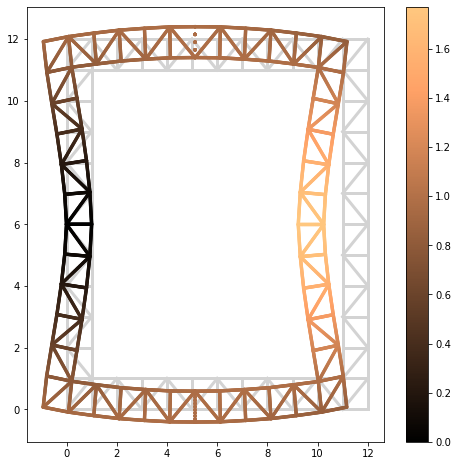

In [7]:
# visualisation code
ex = 1.0               # exaggerate the displacement (for display)
interpolation_num = 40  # how many points to add in each element
num_nodes, num_el, PD = len(nodes), len(conn), len(nodes[0])

x_new = nodes[:, 0] + ex * ext_nodes[:, 8]  # new coordinates x
y_new = nodes[:, 1] + ex * ext_nodes[:, 9]  # new coordinates y
x_old = ext_nodes[:, 0]                    # initial coordinates x
y_old = ext_nodes[:, 1]                    # initial coordinates y
U_abs = np.sqrt(ext_nodes[:,8]**2 + ext_nodes[:, 9]**2)   # absolute displacements

xs, ys, colors = [], [], []    # init plotting points and colors
# plotting the lines with different colors (linearly interpolated points)
for i in range(num_el):  # for each element
    inds = conn[i]
    x1, y1 = x_new[inds[0]], y_new[inds[0]]
    x2, y2 = x_new[inds[1]], y_new[inds[1]]
    if x1 == x2:
        xs_i = np.linspace(x1, x2, interpolation_num)
        ys_i = np.linspace(y1, y2, interpolation_num)
    else:
        a = (y2 - y1)/(x2 - x1)  # slope
        xs_i = np.linspace(x1, x2, interpolation_num)
        ys_i = a*(xs_i - x1) + y1

    xs.append(xs_i)
    ys.append(ys_i)
    colors.append(np.linspace(U_abs[inds[0]], U_abs[inds[1]], interpolation_num))
xs, ys, colors = np.array(xs), np.array(ys), np.array(colors)
xs, ys, colors = xs.flatten(), ys.flatten(), colors.flatten()

f1 = plt.figure(figsize=(8,8)) # init the figure
ax1 = f1.add_subplot(111)      # init the axes

# plotting the original structure
for i in range(num_el):  # for each element
    inds = conn[i]
    x1, y1 = x_old[inds[0]], y_old[inds[0]]
    x2, y2 = x_old[inds[1]], y_old[inds[1]]
    ax1.plot([x1, x2], [y1, y2], linewidth=3, color='lightgray', marker='', zorder=1)

# plotting the new displacements
cmap = plt.get_cmap('copper')
ax1.scatter(xs, ys, c=colors, cmap=cmap, s=12, edgecolor='None', zorder=2)
color_scale = Normalize(np.abs(colors.min()), np.abs(colors.max()))  # scale to use in the colorbar
f1.colorbar(ScalarMappable(norm=color_scale, cmap=cmap))
plt.show()

---
## Animation: Varying Force
- Increasing force on the square outline

In [11]:
# using Truss Analysis for more complicated structure: TRIANGULATED SQUARE OUTLINE
# LOADING: ->[]<-

# material specifications
E = 2000#10.0 ** 6   # Youngs modulus
A = 1#0.01        # cross-section area of a bar



# defining the structure
width, height = 30, 30      # dimensions of the square
num_el_x, num_el_y = 30, 30 # num of elements

dx, dy = width / num_el_x, height / num_el_y

nodes = []
x, y = 0, 0  # OUTER
for i in range(num_el_y-1):  # LEFT
    nodes.append([x, y])
    y += dy
nodes.append([x,y])
y += dy
for i in range(num_el_x-1):  # TOP
    nodes.append([x,y])
    x += dx
nodes.append([x,y])
x += dx
for i in range(num_el_y-1):  # RIGHT
    nodes.append([x, y])
    y -= dy
nodes.append([x,y])
y -= dy
for i in range(num_el_x-1):  # BOTTOM
    nodes.append([x,y])
    x -= dx
nodes.append([x,y])

x, y = dx, dy  # INNER
for i in range(num_el_y-3):  # LEFT
    nodes.append([x, y])
    y += dy
nodes.append([x,y])
y += dy
for i in range(num_el_x-3):  # TOP
    nodes.append([x,y])
    x += dx
nodes.append([x,y])
x += dx
for i in range(num_el_y-3):  # RIGHT
    nodes.append([x, y])
    y -= dy
nodes.append([x,y])
y -= dy
for i in range(num_el_x-3):  # BOTTOM
    nodes.append([x,y])
    x -= dx
nodes.append([x,y])

nodes = np.array(nodes)

num_nodes = len(nodes)              # number of nodes
PD = 2                              # problem dimension: 2D
num_out = 2*(num_el_x + num_el_y)   # nodes in the outer square
num_in = num_nodes - num_out        # nodes in the inner square


conn = []  # init list of connections for each element
outer = [[i, i+1] for i in range(num_out - 1)]
inner = [[i, i+1] for i in range(num_out, num_out + num_in - 1)]  #
cross1 = [[i, i + num_out] for i in range(1, num_el_y - 1)]
cross2 = [[i + num_out -4, i] for i in range(num_el_y + 2, num_el_y + num_el_x)]
cross3 = [[i + num_out - 4, i] for i in range(num_el_y + num_el_x + 1 , num_el_y + num_el_x + num_el_y - 1)]
cross4 = [[i, i + num_out - 8] for i in range(num_out - num_el_x + 2 , num_out )]
horiz1 = [[i, i + num_out - 1] for i in range(1, num_el_y)]
horiz2 = [[i + num_out - 4, i - 1] for i in range(num_el_y + 2, num_el_y + num_el_x + 1)]
horiz3 = [[i + num_out - 4 - 1, i] for i in range(num_el_y + num_el_x + 1 , num_el_y + num_el_x + num_el_y)]
horiz4 = [[i - 1, i + num_out - 8] for i in range(num_out - num_el_x + 2 , num_out)]

corner1 = [0, num_out]
corner2 = [num_el_y-1, num_el_y + 1]
corner3 = [num_nodes - num_el_x - num_el_y + 4, num_el_y + num_el_x]
corner4 = [2*num_el_y + num_el_x + 1, 2*num_el_y + num_el_x - 1]

conn += outer
conn.append([num_out - 1, 0])
conn += inner
conn.append([num_nodes - 1, num_out])
conn.append(corner1)
conn += cross1
conn.append(corner2)
conn += cross2
conn.append(corner3)
conn += cross3
conn.append(corner4)
conn += cross4
conn += horiz1
conn += horiz2
conn += horiz3
conn += horiz4
conn.append([num_out-1, num_out])

conn = np.array(conn)

#plot_nodes(nodes, size=8)                             # plotting the mesh
#plot_mesh(nodes, conn, plot_connections=True, size=8) # plotting the mesh


# assigning boundary conditions (Dirichlet & Neumann BC)
BC = np.ones((num_nodes, PD))  # init the BC conditions
for i in range(num_nodes):
    (x, y) = nodes[i]

    if height / 2 <= y < height / 2 + dy:
        if x < width // 2:
            BC[i, :] = [-1, -1]  # fix the point in X and Y
        # elif x > width // 2:
        #     BC[i, :] = [1, -1]  # fix the point in Y

Fs = np.linspace(0, 24, 49)
for im, f in enumerate(Fs):
    F = np.zeros((num_nodes, PD))
    # assigning nodal forces
    for i in range(num_nodes):
        (x, y) = nodes[i]

        if height / 2 <= y < height / 2 + dy:
            if x > width // 2:
                F[i, :] = [-f, 0]  # fix the point in Y


    # initial displacements
    U = np.zeros((num_nodes, PD))


    # extended node list (ENL)
    (localDOF, globalDOF, DOC, DOF) = get_DOF(nodes=nodes, BC=BC)  # get the DOF matrices
    ext_nodes = np.zeros((num_nodes, 6 * PD))  # nodes, BC, local DoF, global DoF, Displacement, Forces
    ext_nodes[:, 0:PD] = nodes          # first 2 columns are node list
    ext_nodes[:, PD:2*PD] = BC          # boundary conditions
    ext_nodes[:, 2*PD:3*PD] = localDOF  # local DOFs
    ext_nodes[:, 3*PD:4*PD] = globalDOF # global DOFs
    ext_nodes[:, 4*PD:5*PD] = U         # displacements
    ext_nodes[:, 5*PD:6*PD] = F         # forces


    # calculating the global stiffness matrix
    K = get_global_stiffness(nodes=nodes, conn=conn, ext_nodes=ext_nodes, E=E, A=A)
    U, F = U.flatten(), F.flatten()


    # finding the new displacements and forces
    F_p = get_forces(nodes, ext_nodes)        # force prescribed
    U_p = get_displacements(nodes, ext_nodes) # displacement prescribed


    # using F = K * U
    K_UU = K[0:DOF, 0:DOF]
    K_UP = K[0:DOF, DOF:DOF+DOC]
    K_PU = K[DOF:DOF+DOC, 0:DOF]
    K_PP = K[DOF:DOF+DOC, DOF:DOF+DOC]

    F_com = F_p - np.matmul(K_UP, U_p)                            # 'combined' F
    U_new = np.matmul(np.linalg.inv(K_UU), F_com)                 # the nodal displacements
    F_new = np.matmul(K_PU, U_new) + np.matmul(K_PP, U_p)         # the nodal forces
    ext_nodes = update_ext_nodes(nodes, ext_nodes, U_new, F_new)  # matrix with solutions

    # visualisation code
    ex = 1.0               # exaggerate the displacement (for display)
    interpolation_num = 80  # how many points to add in each element
    num_nodes, num_el, PD = len(nodes), len(conn), len(nodes[0])

    x_new = nodes[:, 0] + ex * ext_nodes[:, 8]  # new coordinates x
    y_new = nodes[:, 1] + ex * ext_nodes[:, 9]  # new coordinates y
    x_old = ext_nodes[:, 0]                    # initial coordinates x
    y_old = ext_nodes[:, 1]                    # initial coordinates y
    U_abs = np.sqrt(ext_nodes[:,8]**2 + ext_nodes[:, 9]**2)   # absolute displacements

    xs, ys, colors = [], [], []    # init plotting points and colors
    # plotting the lines with different colors (linearly interpolated points)
    for i in range(num_el):  # for each element
        inds = conn[i]
        x1, y1 = x_new[inds[0]], y_new[inds[0]]
        x2, y2 = x_new[inds[1]], y_new[inds[1]]
        if x1 == x2:
            xs_i = np.linspace(x1, x2, interpolation_num)
            ys_i = np.linspace(y1, y2, interpolation_num)
        else:
            a = (y2 - y1)/(x2 - x1)  # slope
            xs_i = np.linspace(x1, x2, interpolation_num)
            ys_i = a*(xs_i - x1) + y1

        xs.append(xs_i)
        ys.append(ys_i)
        colors.append(np.linspace(U_abs[inds[0]], U_abs[inds[1]], interpolation_num))
    xs, ys, colors = np.array(xs), np.array(ys), np.array(colors)
    xs, ys, colors = xs.flatten(), ys.flatten(), colors.flatten()

    f1 = plt.figure(figsize=(9,9)) # init the figure
    ax1 = f1.add_subplot(111)      # init the axes
    plt.axis('equal')
    plt.ylim((-15,45))
    plt.xlim((-45, 60))

    # plotting the original structure
    for i in range(num_el):  # for each element
        inds = conn[i]
        x1, y1 = x_old[inds[0]], y_old[inds[0]]
        x2, y2 = x_old[inds[1]], y_old[inds[1]]
        ax1.plot([x1, x2], [y1, y2], linewidth=2, color='lightgray', marker='', zorder=1)

    # plotting the new displacements
    cmap = plt.get_cmap('copper')
    ax1.scatter(xs, ys, c=colors, cmap=cmap, s=4, edgecolor='None', zorder=2)
    color_scale = Normalize(np.abs(colors.min()), np.abs(colors.max()))  # scale to use in the colorbar
    f1.colorbar(ScalarMappable(norm=color_scale, cmap=cmap))
    plt.title(f"Force Applied: {f}")
    im_lab = f"{im:03}"
    plt.savefig(f"./img/trussAnimation/{im_lab}.png", transparent=False, edgecolor='white', facecolor='white')
    plt.close(f1)

---
## Timing code

In [8]:
# timing code for v2 FEA
# problem: TRIANGULATED SQUARE OUTLINE LOADING: ->[]<-
# simple tests: small, middle, large sized squares (10, 100, 1000):
# simple and 'randomized' coordinates
import time
from tabulate import tabulate
import pandas as pd
from numpy import random as rd



times_to_run = 4               # timing multiple rounds
S = [10, 100, 500]             # size of the side of square
timings = []                    # timing list for each size iteration
timings_avg = np.zeros(len(S))  # run averages
num_elements = np.zeros(len(S)) # vector of total number of elements
np.random.seed(42)              # fixing the random seed
timings_random1 = []            # timing list for each size iteration
timings_random1_avg = np.zeros(len(S))

# material specifications
E = 2000.0     # Youngs modulus
A = 1.0        # cross-section area of a bar
PD = 2         # problem dimension: 2D

for size in S:
    t0 = time.time()
    for round in range(times_to_run):

        # defining the structure
        width, height = size, size      # dimensions of the square
        num_el_x, num_el_y = size, size # num of elements
        dx, dy = width / num_el_x, height / num_el_y

        nodes = []
        x, y = 0, 0  # OUTER
        for i in range(num_el_y-1):  # LEFT
            nodes.append([x, y])
            y += dy
        nodes.append([x,y])
        y += dy
        for i in range(num_el_x-1):  # TOP
            nodes.append([x,y])
            x += dx
        nodes.append([x,y])
        x += dx
        for i in range(num_el_y-1):  # RIGHT
            nodes.append([x, y])
            y -= dy
        nodes.append([x,y])
        y -= dy
        for i in range(num_el_x-1):  # BOTTOM
            nodes.append([x,y])
            x -= dx
        nodes.append([x,y])

        x, y = dx, dy  # INNER
        for i in range(num_el_y-3):  # LEFT
            nodes.append([x, y])
            y += dy
        nodes.append([x,y])
        y += dy
        for i in range(num_el_x-3):  # TOP
            nodes.append([x,y])
            x += dx
        nodes.append([x,y])
        x += dx
        for i in range(num_el_y-3):  # RIGHT
            nodes.append([x, y])
            y -= dy
        nodes.append([x,y])
        y -= dy
        for i in range(num_el_x-3):  # BOTTOM
            nodes.append([x,y])
            x -= dx
        nodes.append([x,y])

        nodes = np.array(nodes)

        num_nodes = len(nodes)              # number of nodes
        num_out = 2*(num_el_x + num_el_y)   # nodes in the outer square
        num_in = num_nodes - num_out        # nodes in the inner square

        conn = []  # init list of connections for each element
        outer = [[i, i+1] for i in range(num_out - 1)]
        inner = [[i, i+1] for i in range(num_out, num_out + num_in - 1)]  #
        cross11 = [[i, i + num_out] for i in range(1, num_el_y - 1)]
        cross12 = [[i + 1, i + num_out - 1] for i in range(1, num_el_y - 1)]
        cross21 = [[i + num_out -4, i] for i in range(num_el_y + 2, num_el_y + num_el_x)]
        cross22 = [[i + num_out -4 + 1, i - 1] for i in range(num_el_y + 2, num_el_y + num_el_x)]
        cross31 = [[i + num_out - 4, i] for i in range(num_el_y + num_el_x + 1 , num_el_y + num_el_x + num_el_y - 1)]
        cross32 = [[i + num_out - 4 - 1, i + 1] for i in range(num_el_y + num_el_x + 1 , num_el_y + num_el_x + num_el_y - 1)]
        cross41 = [[i, i + num_out - 8] for i in range(num_out - num_el_x + 2 , num_out )]
        cross42 = [[i - 1, i + num_out - 8 + 1] for i in range(num_out - num_el_x + 2 , num_out )]
        horiz1 = [[i, i + num_out - 1] for i in range(1, num_el_y)]
        horiz2 = [[i + num_out - 4, i - 1] for i in range(num_el_y + 2, num_el_y + num_el_x + 1)]
        horiz3 = [[i + num_out - 4 - 1, i] for i in range(num_el_y + num_el_x + 1 , num_el_y + num_el_x + num_el_y)]
        horiz4 = [[i - 1, i + num_out - 8] for i in range(num_out - num_el_x + 2 , num_out)]

        corner1 = [0, num_out]
        corner2 = [num_el_y-1, num_el_y + 1]
        corner3 = [num_nodes - num_el_x - num_el_y + 4, num_el_y + num_el_x]
        corner4 = [2*num_el_y + num_el_x + 1, 2*num_el_y + num_el_x - 1]

        conn += outer
        conn.append([num_out - 1, 0])
        conn += inner
        conn.append([num_nodes - 1, num_out])
        conn.append(corner1)
        conn += cross12[::2]
        conn += cross11[1::2]
        conn.append(corner2)
        conn += cross22[::2]
        conn += cross21[1::2]
        conn.append(corner3)
        conn += cross32[::2]
        conn += cross31[1::2]
        conn.append(corner4)
        conn += cross42[::2]
        conn += cross41[1::2]
        conn += horiz1
        conn += horiz2
        conn += horiz3
        conn += horiz4
        conn.append([num_out-1, num_out])
        conn = np.array(conn)

        #plot_nodes(nodes, size=8)                             # plotting the mesh
        #plot_mesh(nodes, conn, plot_connections=True, size=8) # plotting the mesh

        # assigning boundary conditions (Dirichlet & Neumann BC)
        BC = np.ones((num_nodes, PD))  # init the BC conditions
        for i in range(num_nodes):
            (x, y) = nodes[i]

            if height / 2 <= y < height / 2 + dy:
                if x < width // 2:
                    BC[i, :] = [-1, -1]  # fix the point in X and Y
                # elif x > width // 2:
                #     BC[i, :] = [1, -1]  # fix the point in Y

        # assigning nodal forces
        F = np.zeros((num_nodes, PD))
        for i in range(num_nodes):
            (x, y) = nodes[i]

            if height / 2 <= y < height / 2 + dy:
                if x > width // 2:
                    F[i, :] = [-20, 0]  # fix the point in Y


        # initial displacements
        U = np.zeros((num_nodes, PD))

        # extended node list (ENL)
        (localDOF, globalDOF, DOC, DOF) = get_DOF(nodes=nodes, BC=BC)  # get the DOF matrices
        ext_nodes = np.zeros((num_nodes, 6 * PD))  # nodes, BC, local DoF, global DoF, Displacement, Forces
        ext_nodes[:, 0:PD] = nodes          # first 2 columns are node list
        ext_nodes[:, PD:2*PD] = BC          # boundary conditions
        ext_nodes[:, 2*PD:3*PD] = localDOF  # local DOFs
        ext_nodes[:, 3*PD:4*PD] = globalDOF # global DOFs
        ext_nodes[:, 4*PD:5*PD] = U         # displacements
        ext_nodes[:, 5*PD:6*PD] = F         # forces

        # calculating the global stiffness matrix
        K = get_global_stiffness(nodes=nodes, conn=conn, ext_nodes=ext_nodes, E=E, A=A)
        U, F = U.flatten(), F.flatten()

        # finding the new displacements and forces
        F_p = get_forces(nodes, ext_nodes)        # force prescribed
        U_p = get_displacements(nodes, ext_nodes) # displacement prescribed

        # using F = K * U
        K_UU = K[0:DOF, 0:DOF]
        K_UP = K[0:DOF, DOF:DOF+DOC]
        K_PU = K[DOF:DOF+DOC, 0:DOF]
        K_PP = K[DOF:DOF+DOC, DOF:DOF+DOC]
        F_com = F_p - np.matmul(K_UP, U_p)                            # 'combined' F
        U_new = np.matmul(np.linalg.inv(K_UU), F_com)                 # the nodal displacements
        F_new = np.matmul(K_PU, U_new) + np.matmul(K_PP, U_p)         # the nodal forces
        ext_nodes = update_ext_nodes(nodes, ext_nodes, U_new, F_new)  # matrix with solutions

    t1 = time.time()      # end time
    t_tot = t1 - t0       # total time
    timings.append(t_tot) # recording the tot time
timings_avg += np.array(timings)
timings_avg = timings_avg / times_to_run

for size in S:
    t0 = time.time()
    for round in range(times_to_run):

        # defining the structure
        width, height = size, size      # dimensions of the square
        num_el_x, num_el_y = size, size # num of elements
        dx, dy = width / num_el_x, height / num_el_y

        nodes = []
        x, y = 0, 0  # OUTER
        for i in range(num_el_y-1):  # LEFT
            nodes.append([x, y])
            y += dy
        nodes.append([x,y])
        y += dy
        for i in range(num_el_x-1):  # TOP
            nodes.append([x,y])
            x += dx
        nodes.append([x,y])
        x += dx
        for i in range(num_el_y-1):  # RIGHT
            nodes.append([x, y])
            y -= dy
        nodes.append([x,y])
        y -= dy
        for i in range(num_el_x-1):  # BOTTOM
            nodes.append([x,y])
            x -= dx
        nodes.append([x,y])

        x, y = dx, dy  # INNER
        for i in range(num_el_y-3):  # LEFT
            nodes.append([x, y])
            y += dy
        nodes.append([x,y])
        y += dy
        for i in range(num_el_x-3):  # TOP
            nodes.append([x,y])
            x += dx
        nodes.append([x,y])
        x += dx
        for i in range(num_el_y-3):  # RIGHT
            nodes.append([x, y])
            y -= dy
        nodes.append([x,y])
        y -= dy
        for i in range(num_el_x-3):  # BOTTOM
            nodes.append([x,y])
            x -= dx
        nodes.append([x,y])
        nodes = np.array(nodes)
        perturb = 2 * rd.rand(nodes.shape[0], nodes.shape[1]) - 1
        nodes += 0.25 * perturb  # randomly perturbing nodes

        num_nodes = len(nodes)              # number of nodes
        num_out = 2*(num_el_x + num_el_y)   # nodes in the outer square
        num_in = num_nodes - num_out        # nodes in the inner square

        conn = []  # init list of connections for each element
        outer = [[i, i+1] for i in range(num_out - 1)]
        inner = [[i, i+1] for i in range(num_out, num_out + num_in - 1)]  #
        cross11 = [[i, i + num_out] for i in range(1, num_el_y - 1)]
        cross12 = [[i + 1, i + num_out - 1] for i in range(1, num_el_y - 1)]
        cross21 = [[i + num_out -4, i] for i in range(num_el_y + 2, num_el_y + num_el_x)]
        cross22 = [[i + num_out -4 + 1, i - 1] for i in range(num_el_y + 2, num_el_y + num_el_x)]
        cross31 = [[i + num_out - 4, i] for i in range(num_el_y + num_el_x + 1 , num_el_y + num_el_x + num_el_y - 1)]
        cross32 = [[i + num_out - 4 - 1, i + 1] for i in range(num_el_y + num_el_x + 1 , num_el_y + num_el_x + num_el_y - 1)]
        cross41 = [[i, i + num_out - 8] for i in range(num_out - num_el_x + 2 , num_out )]
        cross42 = [[i - 1, i + num_out - 8 + 1] for i in range(num_out - num_el_x + 2 , num_out )]
        horiz1 = [[i, i + num_out - 1] for i in range(1, num_el_y)]
        horiz2 = [[i + num_out - 4, i - 1] for i in range(num_el_y + 2, num_el_y + num_el_x + 1)]
        horiz3 = [[i + num_out - 4 - 1, i] for i in range(num_el_y + num_el_x + 1 , num_el_y + num_el_x + num_el_y)]
        horiz4 = [[i - 1, i + num_out - 8] for i in range(num_out - num_el_x + 2 , num_out)]

        corner1 = [0, num_out]
        corner2 = [num_el_y-1, num_el_y + 1]
        corner3 = [num_nodes - num_el_x - num_el_y + 4, num_el_y + num_el_x]
        corner4 = [2*num_el_y + num_el_x + 1, 2*num_el_y + num_el_x - 1]

        conn += outer
        conn.append([num_out - 1, 0])
        conn += inner
        conn.append([num_nodes - 1, num_out])
        conn.append(corner1)
        conn += cross12[::2]
        conn += cross11[1::2]
        conn.append(corner2)
        conn += cross22[::2]
        conn += cross21[1::2]
        conn.append(corner3)
        conn += cross32[::2]
        conn += cross31[1::2]
        conn.append(corner4)
        conn += cross42[::2]
        conn += cross41[1::2]
        conn += horiz1
        conn += horiz2
        conn += horiz3
        conn += horiz4
        conn.append([num_out-1, num_out])
        conn = np.array(conn)

        #plot_nodes(nodes, size=8)                             # plotting the mesh
        #plot_mesh(nodes, conn, plot_connections=True, size=8) # plotting the mesh

        # assigning boundary conditions (Dirichlet & Neumann BC)
        BC = np.ones((num_nodes, PD))  # init the BC conditions
        for i in range(num_nodes):
            (x, y) = nodes[i]

            if height / 2 <= y < height / 2 + dy:
                if x < width // 2:
                    BC[i, :] = [-1, -1]  # fix the point in X and Y
                # elif x > width // 2:
                #     BC[i, :] = [1, -1]  # fix the point in Y

        # assigning nodal forces
        F = np.zeros((num_nodes, PD))
        for i in range(num_nodes):
            (x, y) = nodes[i]

            if height / 2 <= y < height / 2 + dy:
                if x > width // 2:
                    F[i, :] = [-20, 0]  # fix the point in Y


        # initial displacements
        U = np.zeros((num_nodes, PD))

        # extended node list (ENL)
        (localDOF, globalDOF, DOC, DOF) = get_DOF(nodes=nodes, BC=BC)  # get the DOF matrices
        ext_nodes = np.zeros((num_nodes, 6 * PD))  # nodes, BC, local DoF, global DoF, Displacement, Forces
        ext_nodes[:, 0:PD] = nodes          # first 2 columns are node list
        ext_nodes[:, PD:2*PD] = BC          # boundary conditions
        ext_nodes[:, 2*PD:3*PD] = localDOF  # local DOFs
        ext_nodes[:, 3*PD:4*PD] = globalDOF # global DOFs
        ext_nodes[:, 4*PD:5*PD] = U         # displacements
        ext_nodes[:, 5*PD:6*PD] = F         # forces

        # calculating the global stiffness matrix
        K = get_global_stiffness(nodes=nodes, conn=conn, ext_nodes=ext_nodes, E=E, A=A)
        U, F = U.flatten(), F.flatten()

        # finding the new displacements and forces
        F_p = get_forces(nodes, ext_nodes)        # force prescribed
        U_p = get_displacements(nodes, ext_nodes) # displacement prescribed

        # using F = K * U
        K_UU = K[0:DOF, 0:DOF]
        K_UP = K[0:DOF, DOF:DOF+DOC]
        K_PU = K[DOF:DOF+DOC, 0:DOF]
        K_PP = K[DOF:DOF+DOC, DOF:DOF+DOC]
        F_com = F_p - np.matmul(K_UP, U_p)                            # 'combined' F
        U_new = np.matmul(np.linalg.inv(K_UU), F_com)                 # the nodal displacements
        F_new = np.matmul(K_PU, U_new) + np.matmul(K_PP, U_p)         # the nodal forces
        ext_nodes = update_ext_nodes(nodes, ext_nodes, U_new, F_new)  # matrix with solutions




    t1 = time.time()      # end time
    t_tot = t1 - t0       # total time
    timings_random1.append(t_tot) # recording the tot time
timings_random1_avg += np.array(timings_random1)
timings_random1_avg = timings_random1_avg / times_to_run


print(timings)
print('\n\nSummary of timing results in a table: v2 FEA timing test')
print('Num of runs for each size:', times_to_run)

df = pd.DataFrame(
    {'Size of square': [str(s) for s in S],
     'Pure square (per run)' : timings_avg,
     'Random perturbation (per run)': timings_random1_avg,
     'AVG pure/random': (np.array(timings_avg) + np.array(timings_random1_avg))/2})
print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))

[0.09573769569396973, 3.462844133377075, 105.98154377937317]


Summary of timing results in a table: v2 FEA timing test
Num of runs for each size: 4
╒══════════════════╤═════════════════════════╤═════════════════════════════════╤═══════════════════╕
│   Size of square │   Pure square (per run) │   Random perturbation (per run) │   AVG pure/random │
╞══════════════════╪═════════════════════════╪═════════════════════════════════╪═══════════════════╡
│               10 │               0.0239344 │                       0.0181122 │         0.0210233 │
├──────────────────┼─────────────────────────┼─────────────────────────────────┼───────────────────┤
│              100 │               0.865711  │                       0.261186  │         0.563449  │
├──────────────────┼─────────────────────────┼─────────────────────────────────┼───────────────────┤
│              500 │              26.4954    │                      36.7154    │        31.6054    │
╘══════════════════╧═══════════════════════

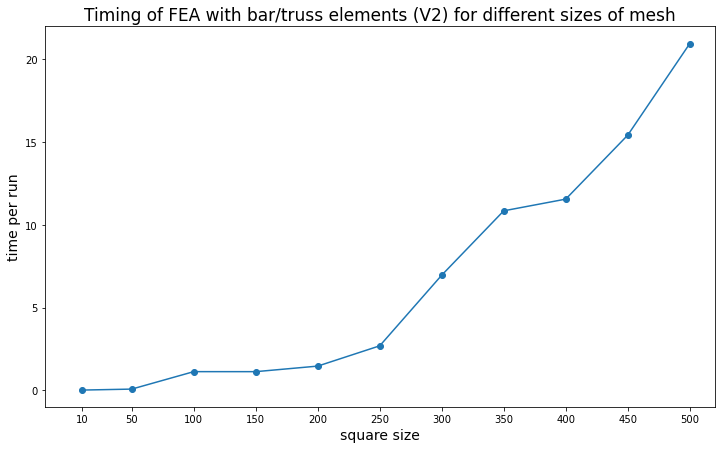

In [16]:
# timing code for v2 FEA: scaling plot
# test: different-sized squares (10, 50, 100, 150, 200, ...)
times_to_run = 2                # timing multiple rounds
S = np.linspace(0,500, 11, dtype=int); S[0] = 10 # sizes to time
timings = []                    # timing list for each size iteration
timings_avg = np.zeros(len(S))  # timing averages
num_elements = []               # total number of elements

for size in S:
    t0 = time.time()
    for round in range(times_to_run):

        # defining the structure
        width, height = size, size      # dimensions of the square
        num_el_x, num_el_y = size, size # num of elements
        dx, dy = width / num_el_x, height / num_el_y

        nodes = []
        x, y = 0, 0  # OUTER
        for i in range(num_el_y-1):  # LEFT
            nodes.append([x, y])
            y += dy
        nodes.append([x,y])
        y += dy
        for i in range(num_el_x-1):  # TOP
            nodes.append([x,y])
            x += dx
        nodes.append([x,y])
        x += dx
        for i in range(num_el_y-1):  # RIGHT
            nodes.append([x, y])
            y -= dy
        nodes.append([x,y])
        y -= dy
        for i in range(num_el_x-1):  # BOTTOM
            nodes.append([x,y])
            x -= dx
        nodes.append([x,y])

        x, y = dx, dy  # INNER
        for i in range(num_el_y-3):  # LEFT
            nodes.append([x, y])
            y += dy
        nodes.append([x,y])
        y += dy
        for i in range(num_el_x-3):  # TOP
            nodes.append([x,y])
            x += dx
        nodes.append([x,y])
        x += dx
        for i in range(num_el_y-3):  # RIGHT
            nodes.append([x, y])
            y -= dy
        nodes.append([x,y])
        y -= dy
        for i in range(num_el_x-3):  # BOTTOM
            nodes.append([x,y])
            x -= dx
        nodes.append([x,y])

        nodes = np.array(nodes)

        num_nodes = len(nodes)              # number of nodes
        num_out = 2*(num_el_x + num_el_y)   # nodes in the outer square
        num_in = num_nodes - num_out        # nodes in the inner square

        conn = []  # init list of connections for each element
        outer = [[i, i+1] for i in range(num_out - 1)]
        inner = [[i, i+1] for i in range(num_out, num_out + num_in - 1)]  #
        cross11 = [[i, i + num_out] for i in range(1, num_el_y - 1)]
        cross12 = [[i + 1, i + num_out - 1] for i in range(1, num_el_y - 1)]
        cross21 = [[i + num_out -4, i] for i in range(num_el_y + 2, num_el_y + num_el_x)]
        cross22 = [[i + num_out -4 + 1, i - 1] for i in range(num_el_y + 2, num_el_y + num_el_x)]
        cross31 = [[i + num_out - 4, i] for i in range(num_el_y + num_el_x + 1 , num_el_y + num_el_x + num_el_y - 1)]
        cross32 = [[i + num_out - 4 - 1, i + 1] for i in range(num_el_y + num_el_x + 1 , num_el_y + num_el_x + num_el_y - 1)]
        cross41 = [[i, i + num_out - 8] for i in range(num_out - num_el_x + 2 , num_out )]
        cross42 = [[i - 1, i + num_out - 8 + 1] for i in range(num_out - num_el_x + 2 , num_out )]
        horiz1 = [[i, i + num_out - 1] for i in range(1, num_el_y)]
        horiz2 = [[i + num_out - 4, i - 1] for i in range(num_el_y + 2, num_el_y + num_el_x + 1)]
        horiz3 = [[i + num_out - 4 - 1, i] for i in range(num_el_y + num_el_x + 1 , num_el_y + num_el_x + num_el_y)]
        horiz4 = [[i - 1, i + num_out - 8] for i in range(num_out - num_el_x + 2 , num_out)]

        corner1 = [0, num_out]
        corner2 = [num_el_y-1, num_el_y + 1]
        corner3 = [num_nodes - num_el_x - num_el_y + 4, num_el_y + num_el_x]
        corner4 = [2*num_el_y + num_el_x + 1, 2*num_el_y + num_el_x - 1]

        conn += outer
        conn.append([num_out - 1, 0])
        conn += inner
        conn.append([num_nodes - 1, num_out])
        conn.append(corner1)
        conn += cross12[::2]
        conn += cross11[1::2]
        conn.append(corner2)
        conn += cross22[::2]
        conn += cross21[1::2]
        conn.append(corner3)
        conn += cross32[::2]
        conn += cross31[1::2]
        conn.append(corner4)
        conn += cross42[::2]
        conn += cross41[1::2]
        conn += horiz1
        conn += horiz2
        conn += horiz3
        conn += horiz4
        conn.append([num_out-1, num_out])
        conn = np.array(conn)

        #plot_nodes(nodes, size=8)                             # plotting the mesh
        #plot_mesh(nodes, conn, plot_connections=True, size=8) # plotting the mesh

        # assigning boundary conditions (Dirichlet & Neumann BC)
        BC = np.ones((num_nodes, PD))  # init the BC conditions
        for i in range(num_nodes):
            (x, y) = nodes[i]

            if height / 2 <= y < height / 2 + dy:
                if x < width // 2:
                    BC[i, :] = [-1, -1]  # fix the point in X and Y
                # elif x > width // 2:
                #     BC[i, :] = [1, -1]  # fix the point in Y

        # assigning nodal forces
        F = np.zeros((num_nodes, PD))
        for i in range(num_nodes):
            (x, y) = nodes[i]

            if height / 2 <= y < height / 2 + dy:
                if x > width // 2:
                    F[i, :] = [-20, 0]  # fix the point in Y


        # initial displacements
        U = np.zeros((num_nodes, PD))

        # extended node list (ENL)
        (localDOF, globalDOF, DOC, DOF) = get_DOF(nodes=nodes, BC=BC)  # get the DOF matrices
        ext_nodes = np.zeros((num_nodes, 6 * PD))  # nodes, BC, local DoF, global DoF, Displacement, Forces
        ext_nodes[:, 0:PD] = nodes          # first 2 columns are node list
        ext_nodes[:, PD:2*PD] = BC          # boundary conditions
        ext_nodes[:, 2*PD:3*PD] = localDOF  # local DOFs
        ext_nodes[:, 3*PD:4*PD] = globalDOF # global DOFs
        ext_nodes[:, 4*PD:5*PD] = U         # displacements
        ext_nodes[:, 5*PD:6*PD] = F         # forces

        # calculating the global stiffness matrix
        K = get_global_stiffness(nodes=nodes, conn=conn, ext_nodes=ext_nodes, E=E, A=A)
        U, F = U.flatten(), F.flatten()

        # finding the new displacements and forces
        F_p = get_forces(nodes, ext_nodes)        # force prescribed
        U_p = get_displacements(nodes, ext_nodes) # displacement prescribed

        # using F = K * U
        K_UU = K[0:DOF, 0:DOF]
        K_UP = K[0:DOF, DOF:DOF+DOC]
        K_PU = K[DOF:DOF+DOC, 0:DOF]
        K_PP = K[DOF:DOF+DOC, DOF:DOF+DOC]
        F_com = F_p - np.matmul(K_UP, U_p)                            # 'combined' F
        U_new = np.matmul(np.linalg.inv(K_UU), F_com)                 # the nodal displacements
        F_new = np.matmul(K_PU, U_new) + np.matmul(K_PP, U_p)         # the nodal forces
        ext_nodes = update_ext_nodes(nodes, ext_nodes, U_new, F_new)  # matrix with solutions

    t1 = time.time()      # end time
    t_tot = t1 - t0       # total time
    timings.append(t_tot) # recording the tot time
    num_elements.append(len(conn))
timings_avg += np.array(timings)
timings_avg = timings_avg / times_to_run


# creating the plot
f1 = plt.figure(figsize=(12,7), facecolor='white')
a1 = f1.add_subplot(111)
a1.plot(S, timings_avg, 'o-')
a1.set_ylabel('time per run', size=14)
a1.set_xlabel('square size', size=14)
a1.set_xticks(S)
a1.set_ylim(-1,22)
a1.set_xlim(-20, np.max(S) + 20)

plt.title(f"Timing of FEA with bar/truss elements (V2) for different sizes of mesh", size=17)
plt.show()


In [17]:
print(timings_avg)

[1.09559298e-02 6.98809624e-02 1.12500095e+00 1.12405145e+00
 1.46030009e+00 2.68606865e+00 6.95798743e+00 1.08460785e+01
 1.15532370e+01 1.54194875e+01 2.09516840e+01]
